In [1160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [1161]:
# 加载数据
file_path = "./TrainDataset2024.xls"  # 数据文件路径
data = pd.read_excel(file_path)

# 检查数据基本信息
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [1162]:
# Step 1: 缺失值处理
# 替换 999 为 NaN
data.replace(999, np.nan, inplace=True)

# 查看缺失值情况
print(data.isnull().sum())

# 对于分类变量，用众数填充
categorical_features = ['ER', 'PgR','HER2', 'TrippleNegative', 'ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage', 'Gene']
for col in categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    data[col] = imputer_cat.fit_transform(data[[col]])

ID                                                     0
pCR (outcome)                                          5
RelapseFreeSurvival (outcome)                          0
Age                                                    0
ER                                                     0
PgR                                                    1
HER2                                                   1
TrippleNegative                                        1
ChemoGrade                                             3
Proliferation                                          2
HistologyType                                          3
LNStatus                                               1
TumourStage                                            0
Gene                                                  88
original_shape_Elongation                              0
original_shape_Flatness                                0
original_shape_LeastAxisLength                         0
original_shape_MajorAxisLength 

In [1163]:
# Check imbalance 
print(f"Ratio of '1' in pCR is {(data['pCR (outcome)']==1).sum() / data['pCR (outcome)'].count()}")
# This Indicate imbalance exsists, potential optimize point

Ratio of '1' in pCR is 0.21265822784810126


In [1164]:
# 对于数值变量，用中位数填充
numerical_features = [col for col in data.columns if col not in categorical_features + ['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']]
imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [1165]:
# Step 3: 数据归一化
# 选择需要归一化的列（通常是数值型特征）
scaler = MinMaxScaler()  # 或者使用 StandardScaler
data[numerical_features] = scaler.fit_transform(data[numerical_features])


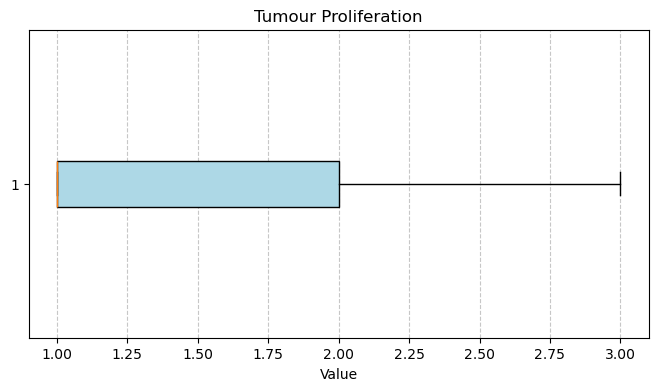

In [1166]:
plt.figure(figsize=(8, 4))
plt.boxplot(data['Proliferation'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Tumour Proliferation')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

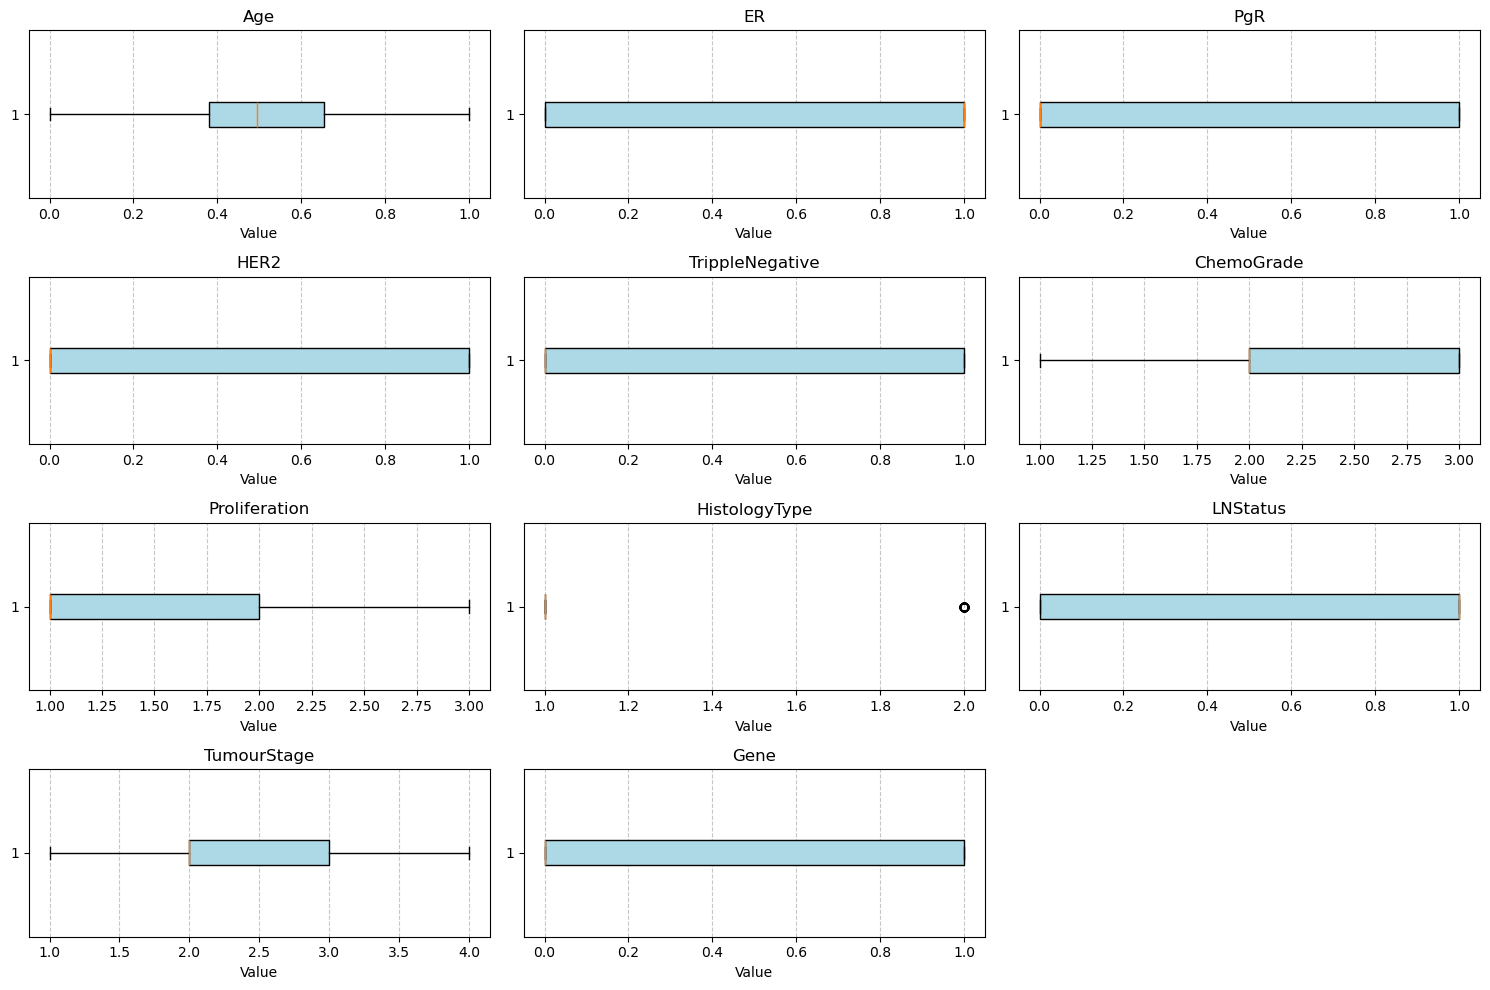

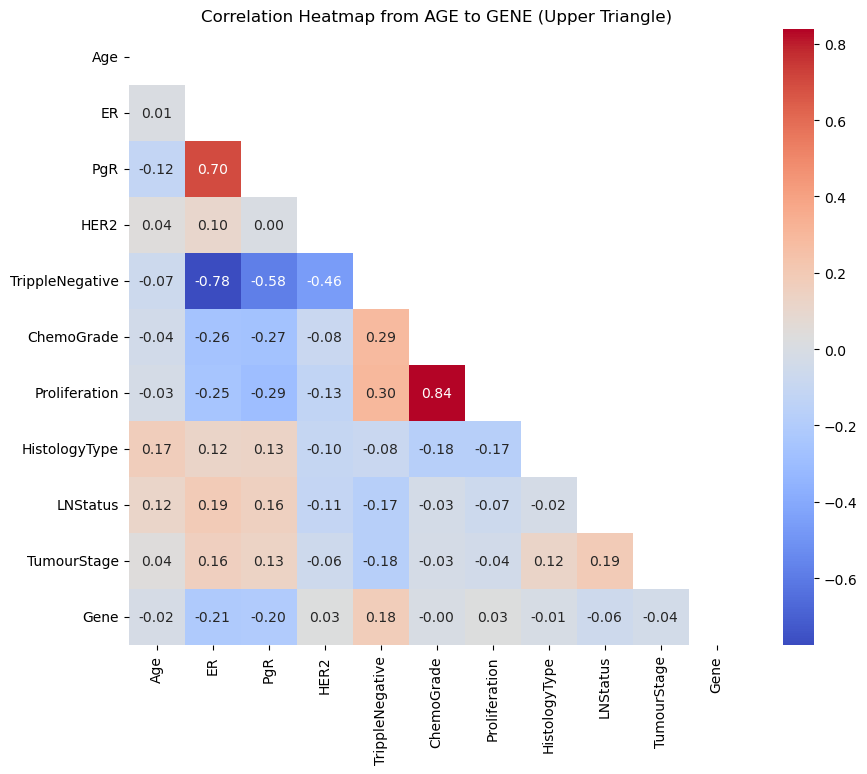

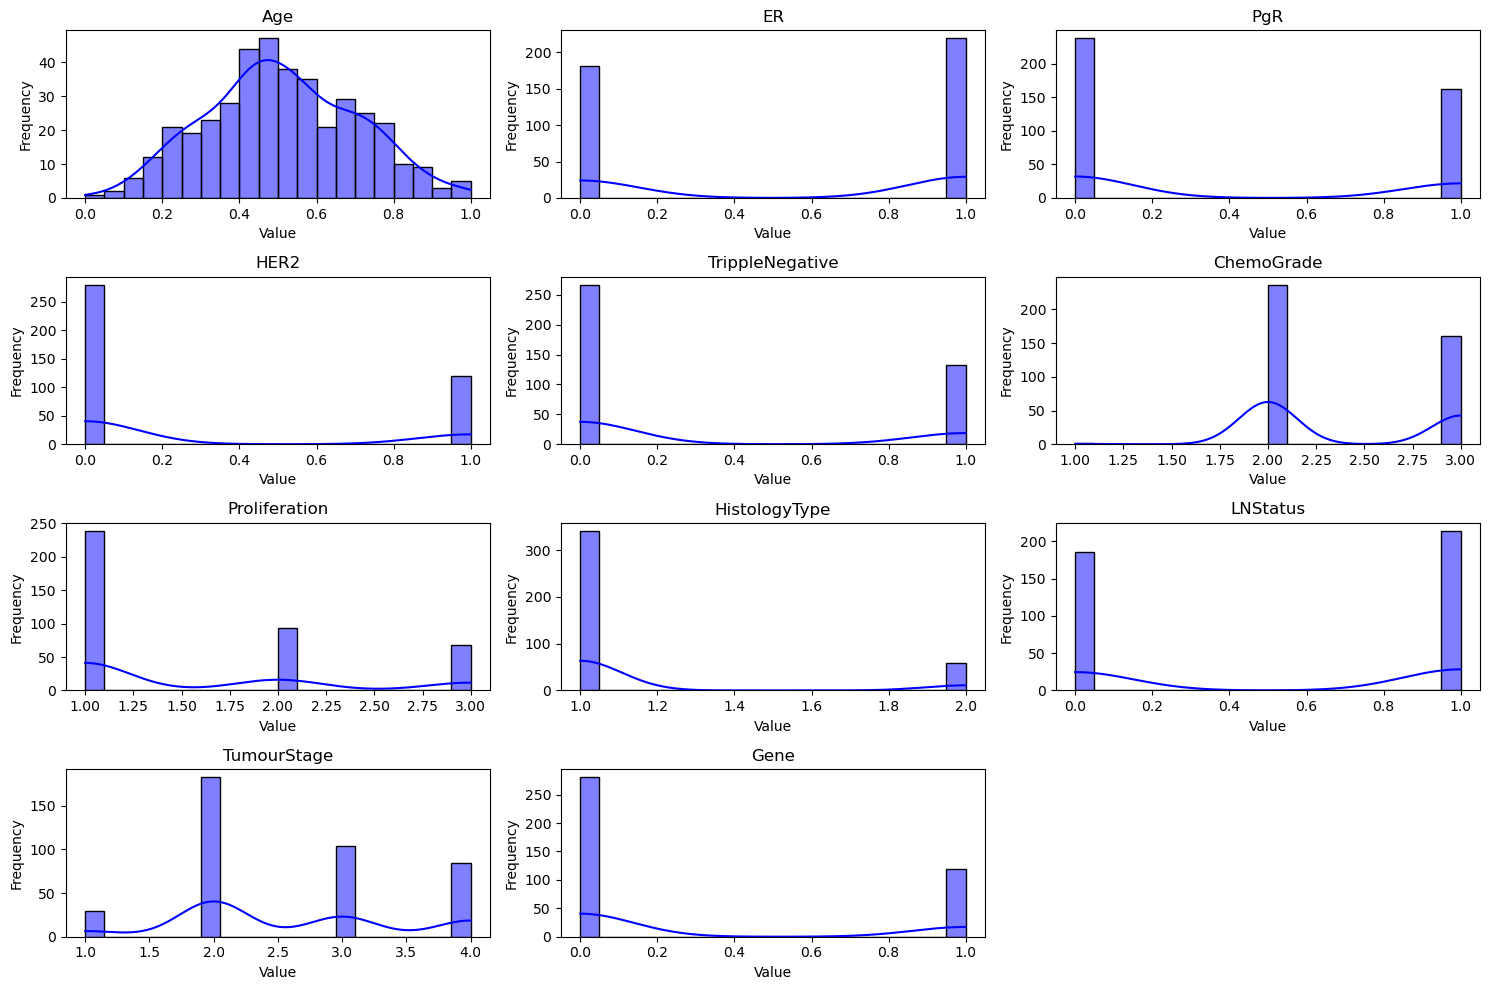

In [1167]:
# 选择 AGE 到 GENE 的列
selected_columns = data.loc[:, 'Age':'Gene']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()

# 使用 Seaborn 绘制热成像分布图

plt.figure(figsize=(10, 8))

# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")

plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [1168]:
# Step 4: 数据划分
# 提取特征和目标变量
X = data.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])  # 去除 ID 和目标列
X_pCr = data[data['pCR (outcome)'].isin([0, 1])]
X_pCr = X_pCr.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']) 

# 分类任务目标
# remove when pCR is absent and pCR is target
y_pcr = data[data['pCR (outcome)'].isin([0, 1])]
y_pcr = y_pcr['pCR (outcome)']
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归任务目标

In [1169]:
print(y_pcr)
(y_pcr==999).sum()

0      1.0
1      0.0
2      1.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
11     1.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     1.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
28     0.0
29     0.0
30     0.0
31     1.0
32     0.0
33     0.0
34     0.0
35     1.0
36     0.0
37     0.0
38     0.0
39     0.0
40     0.0
41     0.0
42     0.0
43     1.0
44     0.0
45     0.0
46     0.0
47     0.0
48     0.0
49     0.0
50     0.0
51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     0.0
68     0.0
69     1.0
70     1.0
71     0.0
72     0.0
73     1.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     0.0
81     0.0
82     1.0
83     1.0
84     0.0
85     0.0
86     0.0
87     1.0
88     1.0
89     1.0
90     0.0
91     0.0

np.int64(0)

In [1170]:
print(y_rfs)

0      144.000000
1      142.000000
2      135.000000
3       12.000000
4      109.000000
5      135.000000
6      139.000000
7       17.000000
8      139.000000
9      138.000000
10     129.000000
11      99.000000
12       7.000000
13      91.000000
14     121.000000
15     117.000000
16      14.000000
17      20.000000
18      10.000000
19     117.000000
20     108.000000
21      12.000000
22     102.000000
23     113.000000
24     112.000000
25      96.000000
26     107.000000
27     102.000000
28     106.000000
29     105.000000
30     107.000000
31      19.000000
32     101.000000
33      20.000000
34      55.000000
35      95.000000
36      96.000000
37      55.000000
38      59.000000
39      29.000000
40      96.000000
41      96.000000
42      98.000000
43      86.000000
44      92.000000
45      59.000000
46      28.000000
47      94.000000
48      94.000000
49      30.000000
50      94.000000
51      37.000000
52      60.000000
53      36.000000
54      85.000000
55      91

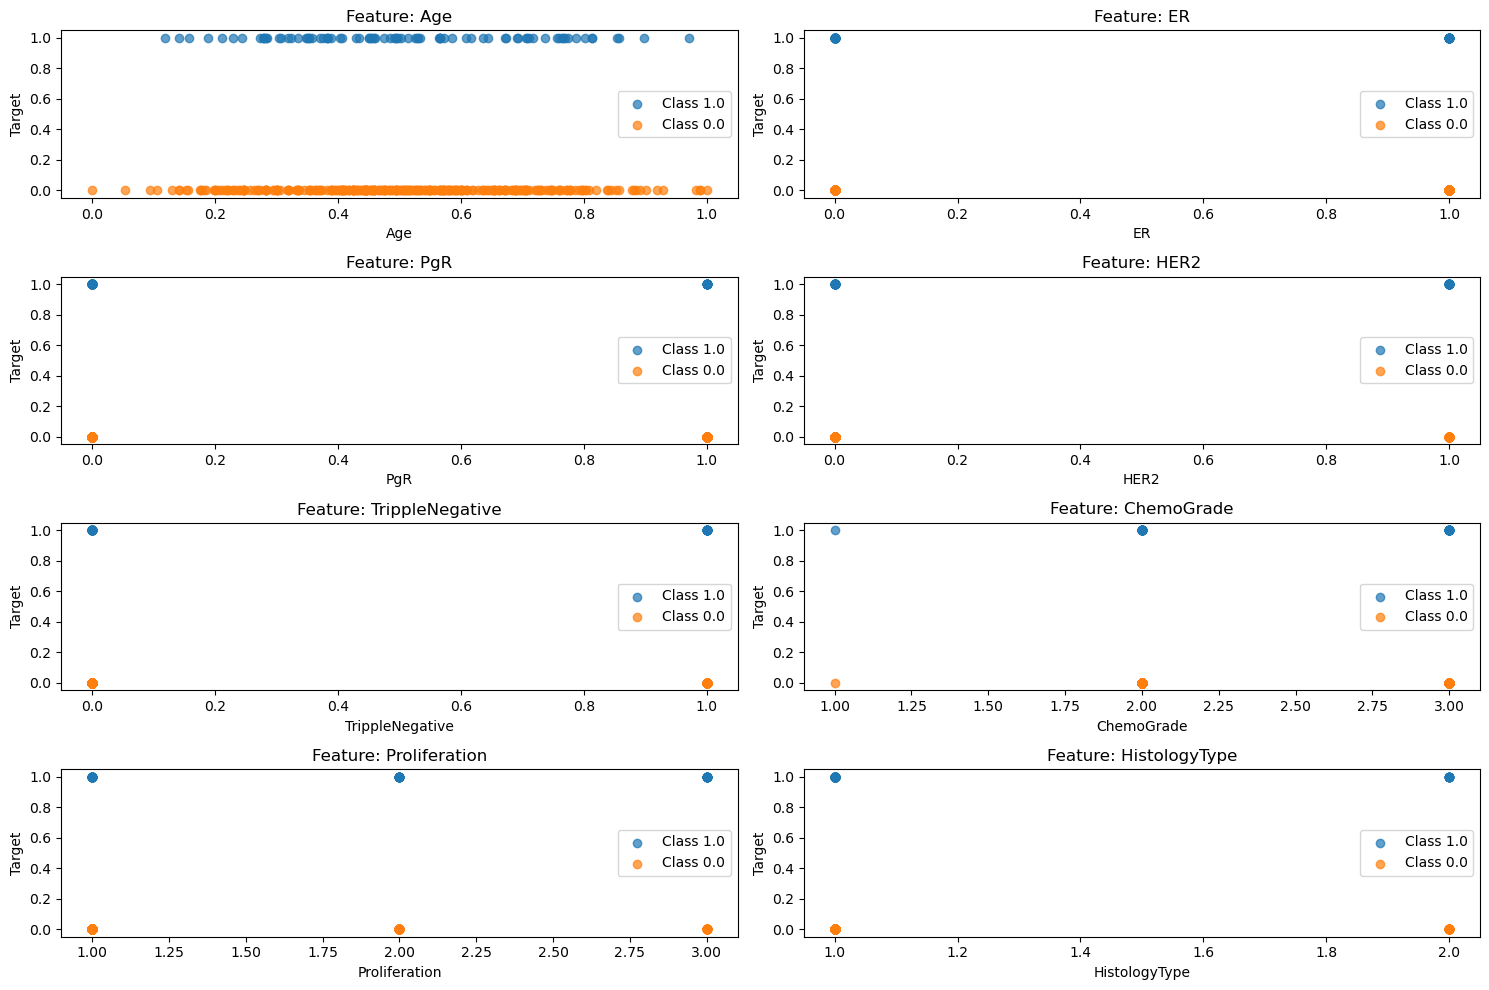

In [1171]:
import matplotlib.pyplot as plt

# Step 1: Select the first 8 features
selected_features = X_pCr.columns[:8]

# Step 2: Plot settings
num_features = len(selected_features)
plt.figure(figsize=(15, 10))

# Step 3: Create scatter plots for first 8 features
for i, feature in enumerate(selected_features):
    plt.subplot((num_features + 1) // 2, 2, i + 1)  # Create a grid layout
    for target_class in y_pcr.unique():
        plt.scatter(
            X_pCr[y_pcr == target_class][feature], 
            [target_class] * len(X_pCr[y_pcr == target_class][feature]), 
            label=f"Class {target_class}", 
            alpha=0.7
        )
    plt.title(f"Feature: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.legend()

plt.tight_layout()
plt.show()

In [1172]:
# 按 8:2 分层划分训练集和验证集
X_train_pcr, X_val_pcr, y_train_pcr, y_val_pcr = train_test_split(
    X_pCr, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(
    X, y_rfs, test_size=0.2, random_state=42
)


In [1173]:
# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features=categorical_features, random_state=42)
#smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pcr, y_train_pcr)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


Class distribution after SMOTE: [249 249]


C:\Users\22519\AppData\Local\Temp\ipykernel_23644\1227655270.py:9: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [1174]:
# Step 5: 检查处理结果
print("训练集和验证集的大小：")
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val_pcr.shape)
print("RFS 训练集:", X_train_rfs.shape, "验证集:", X_val_rfs.shape)

训练集和验证集的大小：
PCR 训练集: (498, 118) 验证集: (79, 118)
RFS 训练集: (320, 118) 验证集: (80, 118)


In [1175]:
# pCR Baseline Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("Before SMOTE")
# Model 0-1: LogisticRegression
lr = LogisticRegression(max_iter = 500,random_state=42)
lr.fit(X_train_pcr, y_train_pcr)
logistic_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, logistic_y_pred))

# Model 0-2: RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pcr, y_train_pcr)
random_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, random_y_pred))

print("After SMOTE")

# Model 1: LogisticRegression
lr = LogisticRegression(max_iter = 500,random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
logistic_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, logistic_y_pred))

# Model 2: RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
random_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, random_y_pred))

Before SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        62
         1.0       0.38      0.18      0.24        17

    accuracy                           0.76        79
   macro avg       0.59      0.55      0.55        79
weighted avg       0.71      0.76      0.72        79


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88        62
         1.0       0.50      0.12      0.19        17

    accuracy                           0.78        79
   macro avg       0.65      0.54      0.53        79
weighted avg       0.74      0.78      0.73        79

After SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78        62
         1.0       0.30      0.41      0.35        17

    accuracy              

In [1176]:
from sklearn.model_selection import cross_val_score, KFold

# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79        62
         1.0       0.32      0.41      0.36        17

    accuracy                           0.68        79
   macro avg       0.57      0.58      0.57        79
weighted avg       0.72      0.68      0.70        79

ROC-AUC:
Cross-Validation Results: [0.92027244 0.89514484 0.87111111 0.87243642 0.84782609]
Mean Score: 0.8813581792208286
Variance of model performance: 0.0006026785402801717

Accuracy:
Cross-Validation Results: [0.82       0.83       0.79       0.7979798  0.80808081]
Mean Accruacy Score: 0.8092121212121212
Variance of model performance: 0.00020901295786144173


Threshold: 0.1, Precision: 0.28, Recall: 0.88, F1: 0.43
Threshold: 0.2, Precision: 0.29, Recall: 0.71, F1: 0.41
Threshold: 0.3, Precision: 0.31, Recall: 0.65, F1: 0.42
Threshold: 0.4, Precision: 0.31, Recall: 0.59, F1: 0.41
Threshold: 0.5, Precision: 0.32, Recall: 0.41, F1: 0.36
Threshold: 0.6, Precision: 0.25, Recall: 0.24, F1: 0.24
Threshold: 0.7, Precision: 0.43, Recall: 0.18, F1: 0.25
Threshold: 0.8, Precision: 0.75, Recall: 0.18, F1: 0.29
Threshold: 0.9, Precision: 0.67, Recall: 0.12, F1: 0.20


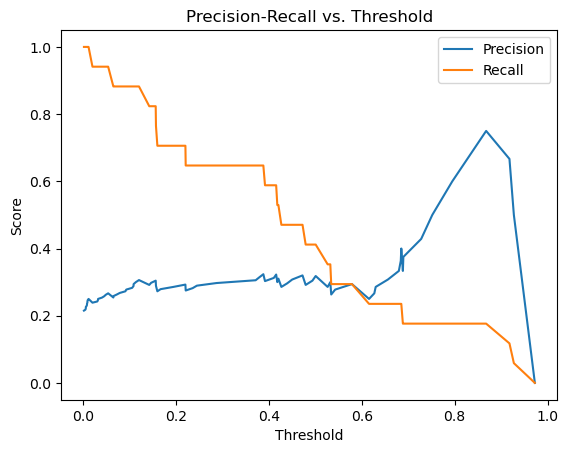

Best Threshold: 0.12032070747306321, Best F1-Score: 0.45454545454545453
Best Threshold (Youden's J): 0.12032070747306321


In [1177]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thershold tuning
y_probs = lr.predict_proba(X_val_pcr)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
    precision = precision_score(y_val_pcr, y_pred)
    recall = recall_score(y_val_pcr, y_pred)
    f1 = f1_score(y_val_pcr, y_pred)
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val_pcr, y_probs)

# Plot the curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision-Recall vs. Threshold')
plt.show()

best_threshold = 0
best_f1 = 0
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_val_pcr, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")
    
from sklearn.metrics import roc_curve

# Get false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_val_pcr, y_probs)

# Compute Youden's J statistic
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]

print(f"Best Threshold (Youden's J): {best_threshold}")


In [1178]:
from sklearn.model_selection import cross_val_score, KFold

# Model 2: RandomForestClassifier
rf = RandomForestClassifier(criterion= 'entropy', max_depth=None, class_weight='balanced', min_samples_leaf=1, min_samples_split=2, n_estimators=200,random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, rf_y_pred))

# Extract feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display ranked features
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(feature_importances)

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(rf, X_pCr, y_pcr, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(rf, X_pCr, y_pcr, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87        62
         1.0       0.50      0.24      0.32        17

    accuracy                           0.78        79
   macro avg       0.66      0.59      0.60        79
weighted avg       0.75      0.78      0.75        79

                                               Feature  Importance
3                                                 HER2    0.042495
2                                                  PgR    0.028810
10                                                Gene    0.023036
1                                                   ER    0.016863
8                                             LNStatus    0.015593
91     original_glrlm_RunLengthNonUniformityNormalized    0.014606
94                     original_glrlm_ShortRunEmphasis    0.014066
106     original_glszm_SizeZoneNonUniformityNormalized    0.013661
109       original_glszm_SmallA

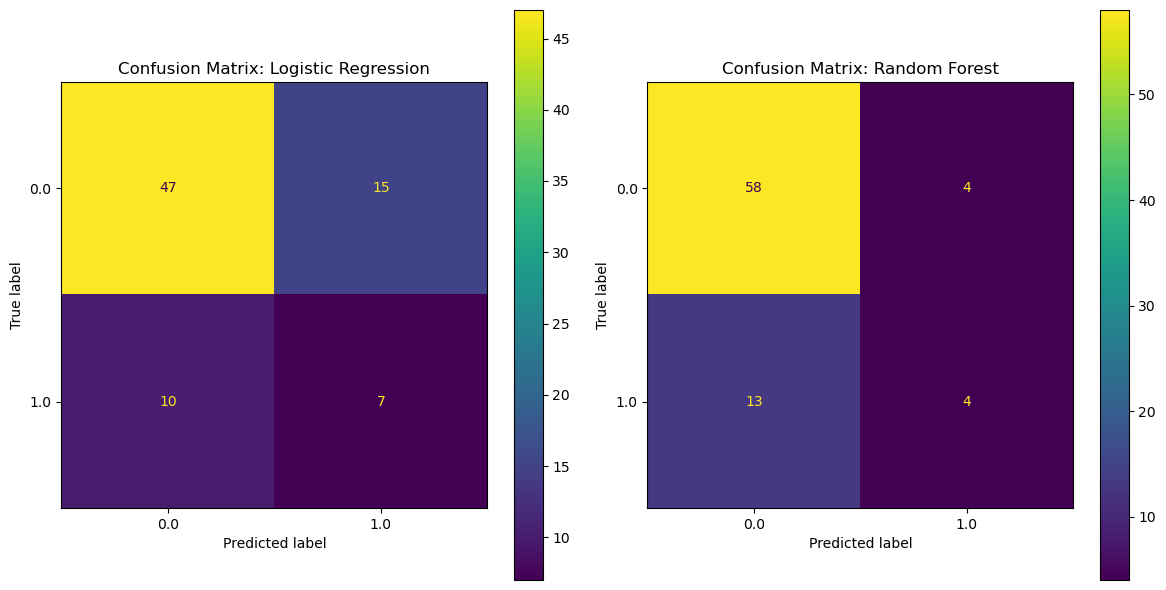

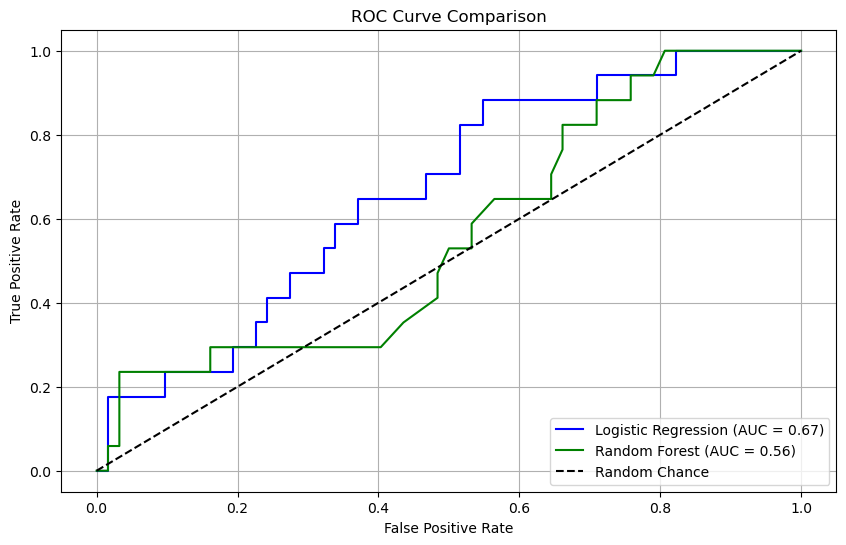

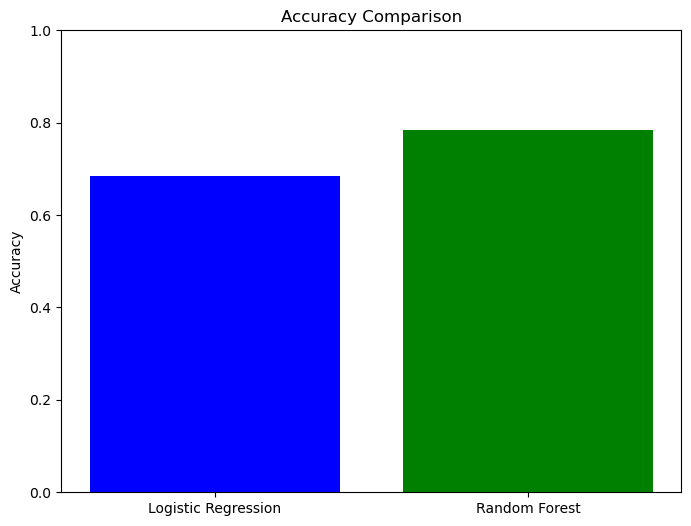

In [1179]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, accuracy_score

# Step 1: Predictions and Probabilities for Logistic Regression
logistic_y_prob = lr.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
logistic_accuracy = accuracy_score(y_val_pcr, lr_y_pred)

# Step 2: Predictions and Probabilities for Random Forest
random_y_prob = rf.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
random_accuracy = accuracy_score(y_val_pcr, rf_y_pred)

# Step 3: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_val_pcr, lr_y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_val_pcr, rf_y_pred, ax=ax[1])
ax[1].set_title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

# Step 4: ROC Curves
logistic_fpr, logistic_tpr, _ = roc_curve(y_val_pcr, logistic_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_val_pcr, random_y_prob)

logistic_auc = auc(logistic_fpr, logistic_tpr)
random_auc = auc(random_fpr, random_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', color='blue')
plt.plot(random_fpr, random_tpr, label=f'Random Forest (AUC = {random_auc:.2f})', color='green')

# Diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot settings
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Bar Chart for Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'], [logistic_accuracy, random_accuracy], color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


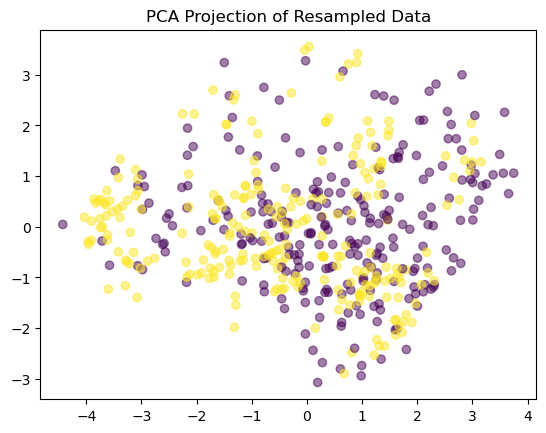

In [1180]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Resampled Data")
plt.show()


In [1181]:
X_train_resampled = X_train_resampled.drop(columns=['TumourStage','ChemoGrade'])  # 去除 ID 和目标列
X_pCr = X_pCr.drop(columns=['TumourStage','ChemoGrade'])  # 去除 ID 和目标列
X_val_pcr = X_val_pcr.drop(columns=['TumourStage','ChemoGrade'])  # 去除 ID 和目标列

# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76        62
         1.0       0.28      0.41      0.33        17

    accuracy                           0.65        79
   macro avg       0.55      0.56      0.55        79
weighted avg       0.70      0.65      0.67        79

ROC-AUC:
Cross-Validation Results: [0.91546474 0.89677683 0.86626263 0.86956522 0.85233798]
Mean Score: 0.8800814789962976
Variance of model performance: 0.0005203928189882365

Accuracy:
Cross-Validation Results: [0.8        0.81       0.79       0.81818182 0.7979798 ]
Mean Accruacy Score: 0.8032323232323233
Variance of model performance: 9.648403224160814e-05


In [1182]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np

# Function to compute bias and variance
def compute_bias_variance(model, X, y, cv=5):
    """
    Estimates bias and variance for a given model using cross-validation.
    Args:
    - model: The machine learning model to evaluate
    - X: Features
    - y: Target variable
    - cv: Number of cross-validation folds

    Returns:
    - Bias: Systematic error of the model
    - Variance: Variability in model predictions
    """
    # Initialize arrays to store predictions and targets
    all_predictions = np.zeros(len(y))
    fold_predictions = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model and predict on the test fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Store predictions in their correct positions
        all_predictions[test_idx] = predictions
        fold_predictions.append(predictions)

    # Convert fold predictions to a numpy array
    fold_predictions = np.array([np.concatenate(fold_predictions)])

    # Compute average predictions
    avg_predictions = np.mean(fold_predictions, axis=0)

    # Compute Bias and Variance
    bias = np.mean((y - avg_predictions) ** 2)
    variance = np.mean((fold_predictions - avg_predictions) ** 2)
    return bias, variance

# Train Random Forest
bias, variance = compute_bias_variance(lr, X_pCr, y_pcr, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")

# Other Metrics
y_pred = lr.predict(X_val_pcr)
y_prob = lr.predict_proba(X_val_pcr)[:, 1]  # For ROC-AUC
accuracy = accuracy_score(y_val_pcr, y_pred)
precision = precision_score(y_val_pcr, y_pred)
recall = recall_score(y_val_pcr, y_pred)
f1 = f1_score(y_val_pcr, y_pred)
roc_auc = roc_auc_score(y_val_pcr, y_prob)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Bias: 0.4278
Variance: 0.0000
Accuracy: 0.7468
Precision: 0.4483
Recall: 0.7647
F1-Score: 0.5652
ROC-AUC: 0.7941
